In [7]:
import glob
import os
import pathlib
import time
import zipfile
import imageio
from matplotlib import cm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from PIL import Image
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances, silhouette_score, silhouette_samples
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, euclidean
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from os import listdir
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
# import requests
# import scipy.ndimage as ndimage

# import tensorflow_addons as tfa
# import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise, Activation, BatchNormalization, Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy
# from scipy.io import loadmat
import mat73
import tqdm
%matplotlib inline

In [8]:
#label indicating the tumor type (1 for meningioma, 2 for glioma, and 3 for pituitary tumor), 
labels = ['meningioma','glioma', 'pituitary']
idx2label = {(idx + 1):label for idx, label in enumerate(labels)}
label2index = {label: (idx+1) for idx, label in enumerate(labels)}
idx2label
label2index

{'meningioma': 1, 'glioma': 2, 'pituitary': 3}

Concatenate mat files into a single file

In [9]:
# Concatenate mat files into a single file

matfiles = []
for file in glob.glob('data/*.mat'):
    mtfile = mat73.loadmat(file)
    mat = {}
    for key, value in mtfile['cjdata'].items():
        mat[key] = value
        matfiles.append(mat)


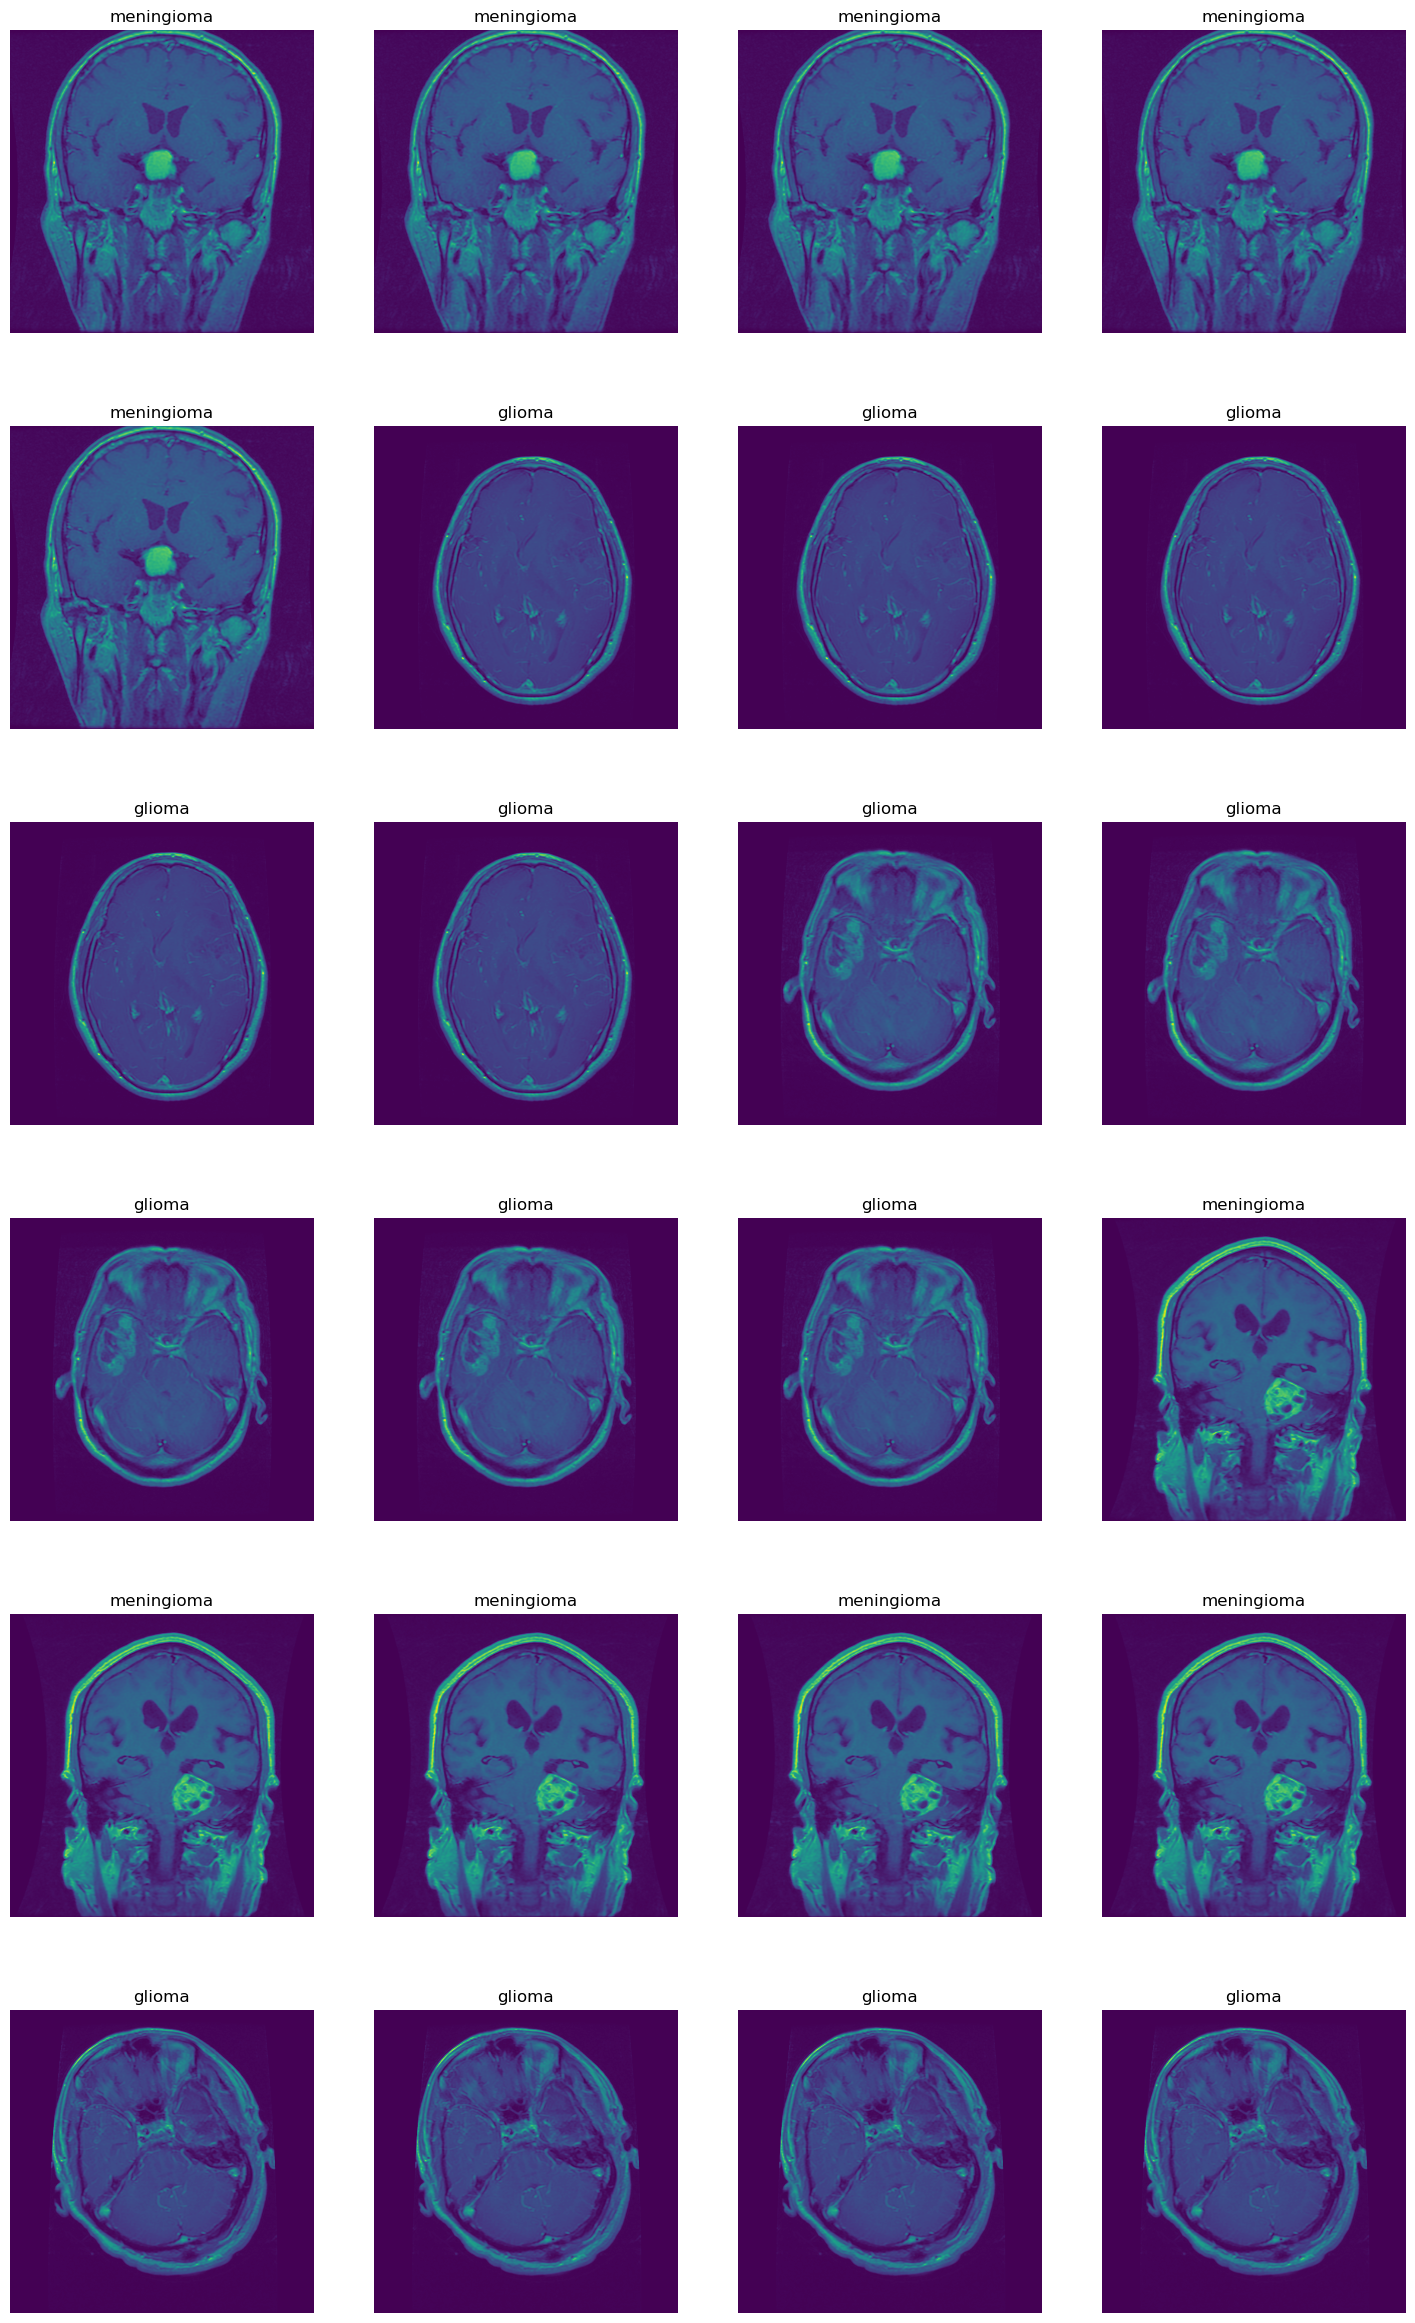

In [11]:
fig, axes= plt.subplots(6,4,figsize=(18,30))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(matfiles[i]['image'])
    ax.set_title(idx2label[int(matfiles[i]['label'])])
    ax.axis('off')

In [12]:
print("Sum of NA values:", sum([matfiles[c]=='NaN' for c in range(len(matfiles))]))
unique, counts = np.unique([matfiles[c]['label'] for c in range(len(matfiles))], return_counts=True)
print("Count of unique label values:", unique,counts)

Sum of NA values: 0
Count of unique label values: [1. 2. 3.] [3540 7130 4650]


In [13]:
matfiles_df = pd.DataFrame(matfiles)
matfiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15320 entries, 0 to 15319
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PID          15320 non-null  object
 1   image        15320 non-null  object
 2   label        15320 non-null  object
 3   tumorBorder  15320 non-null  object
 4   tumorMask    15320 non-null  object
dtypes: object(5)
memory usage: 598.6+ KB


In [14]:
np.unique(matfiles_df.label)

array([array(1.), array(2.), array(3.)], dtype=object)

Save mat files to jpeg images

In [15]:
current_dir = os.getcwd()
dist_dir = os.path.join(current_dir,r'brain_tumor_images')
if not os.path.exists(dist_dir):
    os.makedirs(dist_dir, exist_ok=True)

Store mat files as jpeg images. Save labels, tumorBorders and tumorMasks to lists. Create 3 different directories based on the 3 class tumor types and save images to corresponding folders based on the image label.

In [16]:
# Save mat files to jpeg images

# matfiles = []
# labels = []
# tumorBorders = []
# tumorMasks = []
# for file in glob.glob('data/*.mat'):
#     mtfile = mat73.loadmat(file)
#     img = mtfile['cjdata']['image']
#     label = int(mtfile['cjdata']['label'])
#     tumorBorder = mtfile['cjdata']['tumorBorder']
#     tumorMask = mtfile['cjdata']['tumorMask']
#     labels.append(label)
#     tumorBorders.append(tumorBorder)
#     tumorMasks.append(tumorMask)
#     img = np.array(img, dtype=np.float32)
#     label_dir = idx2label[label]
#     fname = label_dir + "_" + os.path.splitext(file)[0].split('/')[1]
#     new_dir = os.path.join(dist_dir, label_dir)
#     os.makedirs(new_dir,exist_ok=True)    
#     plt.imsave(new_dir + "/{}.jpg".format(fname), img, cmap='gray')
    

Store labels as a pickle file

In [17]:
pickle_out = open(dist_dir + "/labels.pickle","wb")                    
pickle.dump(labels, pickle_out)
pickle_out.close() 

Store tumorBorder as a pickle file

In [18]:
pickle_out = open(dist_dir + "/tumorBorders.pickle","wb")                    
pickle.dump(tumorBorders, pickle_out)
pickle_out.close() 

NameError: name 'tumorBorders' is not defined

Store tumorBorder as a pickle file

In [ ]:
pickle_out = open(dist_dir + "/tumorMasks.pickle","wb")                    
pickle.dump(tumorMasks, pickle_out)
pickle_out.close() 

In [ ]:
# p = os.listdir(dist_dir + '/pituitary')
# print(p)

In [19]:
batch_size = 32
target_size = (224, 224)

Create a data augmentation function. Augment images and save the resulting images to the corresponding directories based on the image label. Prefix augmented images with "aug" to distguish the from the original images.

In [20]:
def img_augment(source_dir, sample_mult,labels):
    labels = ['meningioma','glioma', 'pituitary'] 
    data_gen = ImageDataGenerator(rescale=1.0/255,
                              rotation_range=10, 
                              width_shift_range=0.1, 
                              height_shift_range=0.1, 
                              shear_range=0.1, 
                              brightness_range=(0.3, 1.0),
                              horizontal_flip=True, 
                              vertical_flip=True, 
                              fill_mode='nearest'
                              )

    for label in labels:
        new_dir = os.path.join(source_dir, label)
        os.makedirs(new_dir,exist_ok=True)
        for filename in listdir(new_dir):
            try:
                fname = filename.split("_")[0]
                img = cv2.imread(new_dir + "/" + filename)
                # reshape the image
                img = img.reshape((1,) + img.shape)

                # prefix file names with augment for the new generated images
                prefix = 'aug_' + filename[:-4]
                i = 0
                for batch in data_gen.flow(x=img, batch_size=1,save_to_dir=new_dir, save_prefix=prefix, save_format='jpg'):
                    i+=1
                    if i > sample_mult[fname]:
                        break
            except Exception:
                pass

Create a dictionary with tumor class and weights to balance the dataset using augmentation and apply img augmentation in each directory.

In [21]:
start_time = time.time()
labels = ['meningioma','glioma', 'pituitary']
sample_mult = {'meningioma':5,'glioma':1, 'pituitary':3}
#img_augment(dist_dir, sample_mult, labels)

Create a function to summarize the data after data augmentation.

In [22]:
def data_summary(source_dir):
    samples = {}
    total = 0
    count = 0
    for label in labels:
        new_dir = os.path.join(source_dir, label)
        count = len(listdir(new_dir))
        total +=count
        samples[label] = count
    print(f"The total number of data samples: {total}")
    for i, j in samples.items():
        print(f"The percentage of {i} samples: {round((j/total)*100.0,2)}%, number of {i} samples: {j}" )  
    

Calculate the the number of samples of each type of brain tumor samples after data augmentation. data samples for each class is more balanced now with data augmentation excercise.

In [23]:
data_summary(dist_dir)

The total number of data samples: 13887
The percentage of meningioma samples: 35.7%, number of meningioma samples: 4957
The percentage of glioma samples: 30.81%, number of glioma samples: 4279
The percentage of pituitary samples: 33.49%, number of pituitary samples: 4651


Load the images, resize and normalize and save them into an array. class labels are extracted by using the dictionary label2idx that was created earlier.

In [24]:
def load_data (source_dir,labels,image_size):
    X = []
    y = []
    # loop through folders for each type of brain tumor images
    for label in labels:
        new_dir = os.path.join(source_dir, label)
        for filename in listdir(new_dir):
            try:
                # load image
                img = cv2.imread(new_dir + "/" + filename)
                # resize image
                img = cv2.resize(img, dsize=image_size, interpolation=cv2.INTER_AREA)
                # normalize image
                img = img/255.0
                X.append(img)
                y.append(int(label2idx[label]))
            except Exception:
                pass
            
    X = np.array(X)
    y = np.array(y)
    
    return X, y
    

Load data to X variable and y label.

In [25]:
X, y = load_data(dist_dir, labels, target_size)

Split the data into training, validation and test sets.

In [26]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.1,stratify =y)

In [27]:
X_train, X_val, y_train,y_val = train_test_split(X,y,test_size = 0.1,stratify =y)

One-Hot-Encoding y_train, y_val and y_test labels 

In [28]:
#y_train = to_categorical(y_train)

In [29]:
#y_val = to_categorical(y_val)

In [30]:
#y_test = to_categorical(y_test)

Create a tensorflow for the train and val datasets.

In [31]:
shuffle_buffer = 1000
batch_size = 256
prefetch_buffer = 5
#AUTOTUNE = tf.X.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(shuffle_buffer).batch(batch_size).prefetch(prefetch_buffer)
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(shuffle_buffer).batch(batch_size).prefetch(prefetch_buffer)

In [ ]:
# VGG16 Model

Loading VGG16 pre-trained model

In [32]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3),
include_top = False, 
weights = 'imagenet')

In [33]:
for layer in base_model.layers:
    layer.trainable = False

In [34]:
x = Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = vgg16_model.compile(optimizer = Adam(), loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
vgg16_model.summary()Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
#x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = Dense(3, activation='softmax')(x)

vgg16_model = Model(base_model.input, x)



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [35]:
vgg16_hist = vgg16_model.fit(train_ds, validation_data = val_ds, epochs = 10)

2023-04-23 16:57:50.419990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [12495]
	 [[{{node Placeholder/_1}}]]
2023-04-23 16:57:50.424502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [12495]
	 [[{{node Placeholder/_1}}]]


Epoch 1/10


2023-04-23 17:07:35.931131: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 3 1 1 1 2 1 1 3 1 1 2 1 2 3 2 3 1 3 1 2 3 1 2 1 1 1 3 2 1 2 2 1 2 1 1 3 1 2 3 3 2 1 2 2 1 3 1 2 3 1 3 2 2 2 2 3 3 2 1 3 2 3 3 3 3 1 1 2 2 2 1 1 2 1 3 2 2 2 3 3 3 3 3 1 3 2 1 1 3 3 3 1 2 2 1 3 2 1 3 3 1 1 3 2 2 2 1 2 3 2 3 1 3 3 2 1 3 2 1 1 1 1 3 2 1 3 2 1 1 1 3 3 2 2 1 2 1 1 3 1 3 1 1 2 2 2 2 2 3 1 3 1 1 3 1 3 3 2 2 3 3 1 3 2 2 3 3 3 2 2 3 1 3 2 2 1 1 1 1 2 1 2 1 2 1 1 3 3 1 2 3 3 1 1 3 1 2 1 2 1 1 1 2 3 1 1 1 3 1 1 1 3 1 3 2 3 3 2 1 3 3 3 3 1 3 1 2 1 2 3 1 2 3 3 2 3 3 3 3 1 3 2 1 3 3 3 1 3 2 3 2 3 2 3 1 3
2023-04-23 17:07:36.007527: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Received a lab

InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/Users/boutaina/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/boutaina/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/boutaina/anaconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/boutaina/anaconda3/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/Users/boutaina/anaconda3/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/zm/4bg1fmwj5mj3cwqplf_k2qhw0000gn/T/ipykernel_8337/2760243060.py", line 1, in <module>
      vgg16_hist = vgg16_model.fit(train_ds, validation_data = val_ds, epochs = 10)
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/keras/losses.py", line 2078, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/Users/boutaina/anaconda3/lib/python3.10/site-packages/keras/backend.py", line 5660, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 3 1 1 1 2 1 1 3 1 1 2 1 2 3 2 3 1 3 1 2 3 1 2 1 1 1 3 2 1 2 2 1 2 1 1 3 1 2 3 3 2 1 2 2 1 3 1 2 3 1 3 2 2 2 2 3 3 2 1 3 2 3 3 3 3 1 1 2 2 2 1 1 2 1 3 2 2 2 3 3 3 3 3 1 3 2 1 1 3 3 3 1 2 2 1 3 2 1 3 3 1 1 3 2 2 2 1 2 3 2 3 1 3 3 2 1 3 2 1 1 1 1 3 2 1 3 2 1 1 1 3 3 2 2 1 2 1 1 3 1 3 1 1 2 2 2 2 2 3 1 3 1 1 3 1 3 3 2 2 3 3 1 3 2 2 3 3 3 2 2 3 1 3 2 2 1 1 1 1 2 1 2 1 2 1 1 3 3 1 2 3 3 1 1 3 1 2 1 2 1 1 1 2 3 1 1 1 3 1 1 1 3 1 3 2 3 3 2 1 3 3 3 3 1 3 1 2 1 2 3 1 2 3 3 2 3 3 3 3 1 3 2 1 3 3 3 1 3 2 3 2 3 2 3 1 3
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_1525]

In [ ]:
# ResNet50 Model

In [36]:
Loading ResNet50 pre-trained model

SyntaxError: invalid syntax (2986991158.py, line 1)

In [37]:
from tensorflow.keras.applications import ResNet50

ResNet50_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

94765736/94765736 [==============================] - 8s 0us/step


In [38]:
for layer in base_model.layers:
    layer.trainable = False

In [39]:
ResNet50_model = Sequential()
ResNet50_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
ResNet50_model.add(Dense(512, activation='relu'))
ResNet50_model.add(Dense(3, activation='softmax'))
ResNet50_model.compile(optimizer = Adam(), loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
ResNet50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,638,339
Trainable params: 24,585,219
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
ResNet50_hist = ResNet50_model.fit(train_ds, validation_data = val_ds, epochs = 10)

Epoch 1/10


In [ ]:
# efficientnetB7 Model

In [ ]:
import efficientnet.keras as efn

In [ ]:
base_model = efn.EfficientNetB7(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 3 node for classification output
outputs = Dense(3, activation="softmax")(x)
efficientnet_model = Model(input = base_model.input, output = outputs)

In [ ]:
efficientnet_model.compile(optimizer = Adam(), loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
efficientnet_model.summary()

In [ ]:
efficientnet_hist = efficientnet_model.fit(train_ds, validation_data = val_ds, epochs = 10)

In [ ]:
np.unique(y_train)

In [ ]:
#plt.imshow(matfiles_df['image'][15320])
#matfiles_df['image'].shape
num1, c1 = np.unique(shp, return_counts=True)  
num1, c1

In [ ]:
shp = []
for i in range(len(matfiles)):
    s = matfiles_df['image'][i].shape[1]
    shp.append(s)

In [ ]:
num2, c2 = np.unique(shp, return_counts=True)  
num2, c2